# Laboratorio 1 - Regresión

## Grupo 15
## Integrantes

- Daniel Felipe Ortiz - 202221234
- Javier Barrera - 202214779
- Juan Diego Osorio - 202220148

# Carga de Datos

In [1]:
import numpy as np
import pandas as pd

from joblib import dump, load

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import scipy.stats as stats

data_location = './train_data.csv'

star_df = pd.read_csv(data_location, sep=',', encoding = "ISO-8859-1") 
star_df.sample(5)

,objid,ra,dec,u,g,r,i,z,run,camcol,field,score,clean,class,redshift,mjd,rowv,colv
1769,1237648704048857135,203.129520,-0.388390,18.40142,18.28341,18.14622,18.24338,18.09420,752,3,398,0.900537,1,QSO,0.958311,51955,-0.001404,0.001530
795,1237648720688316427,167.263540,-0.429065,19.17924,19.07219,18.84341,18.77594,18.84654,756,2,344,0.885638,1,QSO,1.330264,51900,0.001714,0.002733
2369,1237648722306990245,185.677904,0.768362,19.49739,17.96166,17.41269,17.20545,17.11567,756,5,467,0.862906,1,STAR,0.000087,54140,-0.000826,-0.001974
3524,1237648703512510812,204.417977,-0.785963,19.46139,17.83446,16.94159,16.48693,16.11856,752,2,406,0.837981,1,GALAXY,0.113320,51955,-0.003949,0.005078
2574,1237648720139452613,139.980556,-0.997995,18.39106,17.28278,16.74216,16.35270,16.20357,756,1,161,0.785099,1,GALAXY,0.095876,58930,0.001357,0.001524


# 1. Entendimiento de los datos

En este punto se nos pide describir las características más relevantes de los datos y todo el perfilamiento de datos, incluir el análisis de calidad de datos y hacer una preselección de las variables más importantes para la etapa de modelado.

El primer paso para esto es una comparación del dataframe con el diccionario de datos. Al realizar una pequeña observación de los tipos de datos que se encuentran en el dataframe y en el diccionario de datos podemos concluir lo siguiente: no se encuentra la columna `objid` que lleva un identificador único por cada registro según la información en el enunciado del laboratorio. En cuanto a las demás columnas se encuentran bien definidas en ambos lugares.

In [2]:
star_df.dtypes

objid         int64
ra          float64
dec         float64
u           float64
g           float64
r           float64
i           float64
z           float64
run           int64
camcol        int64
field         int64
score       float64
clean         int64
class        object
redshift    float64
mjd           int64
rowv        float64
colv        float64
dtype: object

## Caracteristicas mas importantes

Primero que todo es necesario mencionar que en este análisis no vamos a incluir `objid`, `camcol`, `field`, `class` y `mjd` ya que sus estadisticos no nos aportan valor. Los identificadores no nos dan información propiamente de los datos mas allá de identificarlos de manera "única". En cuanto a la columna y la sección de la columna en la que se capturo tampoco nos importa demasiado ya que la toma se pudo realizar en varios lugares distintos y esto no influye sobre la clase del objeto o el corrimiento al rojo. Una manera de pensarlo es ubicar una silla en un salon, la ubicación de la silla no determina propiedades de la misma. Si la silla es roja y se ubica en distintos lugares no cambia el hecho de que es roja. En cuanto a `class` y `run` los estadisticos no nos darían información relevante. En el caso de `class` debido a que es una variable categorica y sobre `run` no nos provee información útil saber la media del número de observaciones realizadas por el telescopio.  


Una vez dejado de lado las anteriores carácteristicas y al hallar las estadisticas de las demás columnas notamos que aquellas que nos indican la magnitud del objeto capturado en algún filtro (`u`, `g`, `r`, `i` y `z`) tienen una desviación estandar pequeña en comparación al rango que toman los datos en el conjunto de datos. Esto nos indica que la varianza entre datos no es considerable. Una primera hipotesis que surge es que estas caracteristicas se encuentran bien distribuidas, lo cual verificaremos en un momento. En cuanto al `score` notamos que este también se encuentra bien distribuido ya que la desviación estandar es pequeña en comparación al rango que toman los datos. Además, la media se encuentra en `0.85`, lo cual nos indica que gran parte de los datos son observaciones de calidad. Esto también se puede verificar con los cuantiles ya que para el 25%, 50% y 75% de los datos se tiene que son valores cercanos a 0.85. En cuanto a `rowv` y `colv` las medias son cercanas a 0, esto también se apoya con los cuantiles. 

In [3]:
exclude = ['objid', 'camcol', 'field', 'class', 'mjd', 'run']
describe_df = star_df.drop(columns=exclude)

describe_df.describe()

,ra,dec,u,g,r,i,z,score,clean,redshift,rowv,colv
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,185.523295,0.248959,18.609049,17.363397,16.839856,16.597712,16.439392,0.851765,0.895500,0.134015,0.000218,-0.000090
std,41.689446,2.001075,0.839431,0.950964,1.055343,1.141252,1.190502,0.071311,0.305946,0.379742,0.008794,0.007457
min,10.469743,-1.252763,13.551780,12.974870,12.362850,12.010790,11.799530,0.301912,0.000000,-0.003322,-0.264516,-0.168807
25%,162.474666,-0.631824,18.170375,16.796110,16.190785,15.870782,15.628205,0.836866,1.000000,0.000106,-0.001212,-0.001609
50%,195.815451,0.053336,18.843745,17.472525,16.850835,16.571195,16.402665,0.860675,1.000000,0.032038,0.000322,0.000125
75%,214.348425,0.593396,19.261563,17.997818,17.506640,17.258833,17.147037,0.879834,1.000000,0.086479,0.001698,0.001672
max,249.758313,13.854010,19.599750,22.497450,22.265960,28.179630,20.847690,0.961145,1.000000,4.192597,0.181871,0.128814


En el punto anterior se menciono que la magnitud del objeto capturado por el filtro se encontraba bien distribuido. Esto se puede evidenciar en las siguiente gráficas a excepción de la primera. La caracteristica del filtro ultravioleta (`u`) parece ser una campana de Gauss cortada a la mitad. En cuanto a las demás se puede observar cierta normalidad en su distribución. Lo cual comprueba a medias la hipotesis anterior. 

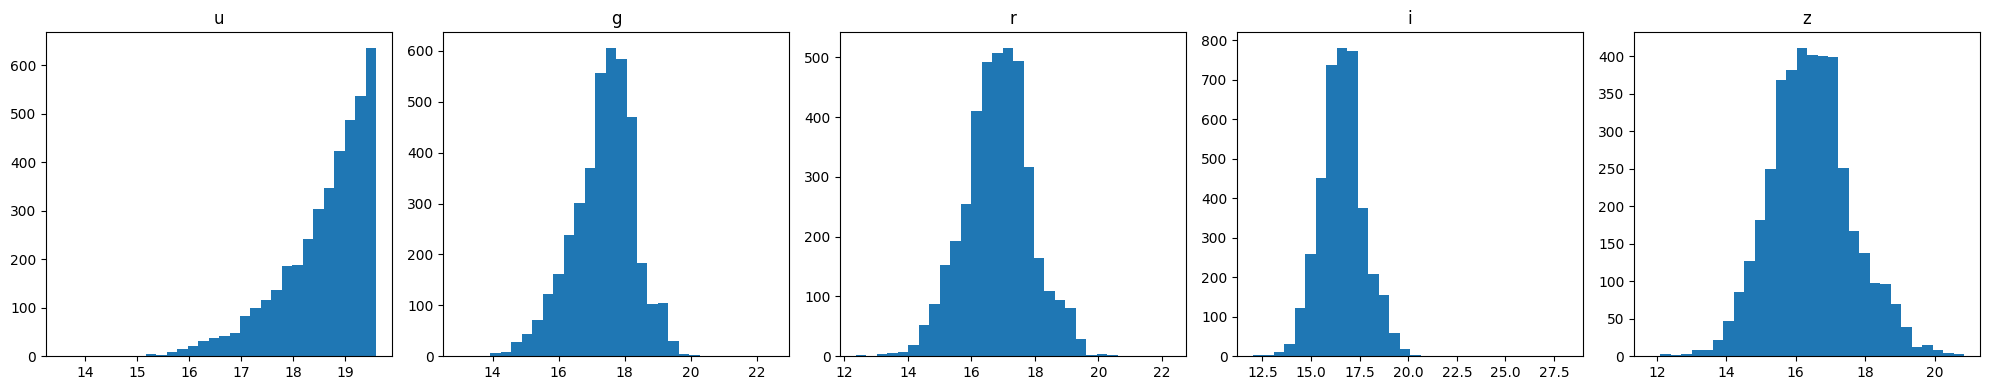

In [4]:
filter_features = ['u', 'g', 'r', 'i', 'z']
fig, axis = plt.subplots(1, len(filter_features), tight_layout=True, figsize=(20,4))

for i, feature in enumerate(filter_features):
    axis[i].hist(describe_df[feature], bins=30)
    axis[i].set_title(feature)

plt.show()

En las siguiente gráficas se decide no incluir `redshift` para hacer un análisis más detallado y `clean` porque son valores de 0 o 1. Notemos de las gráficas que `score` tiende a tener una distribución casi que normal. En cuanto a la velocidad horizontal y vertical hay bastantes valores proximos a 0. 

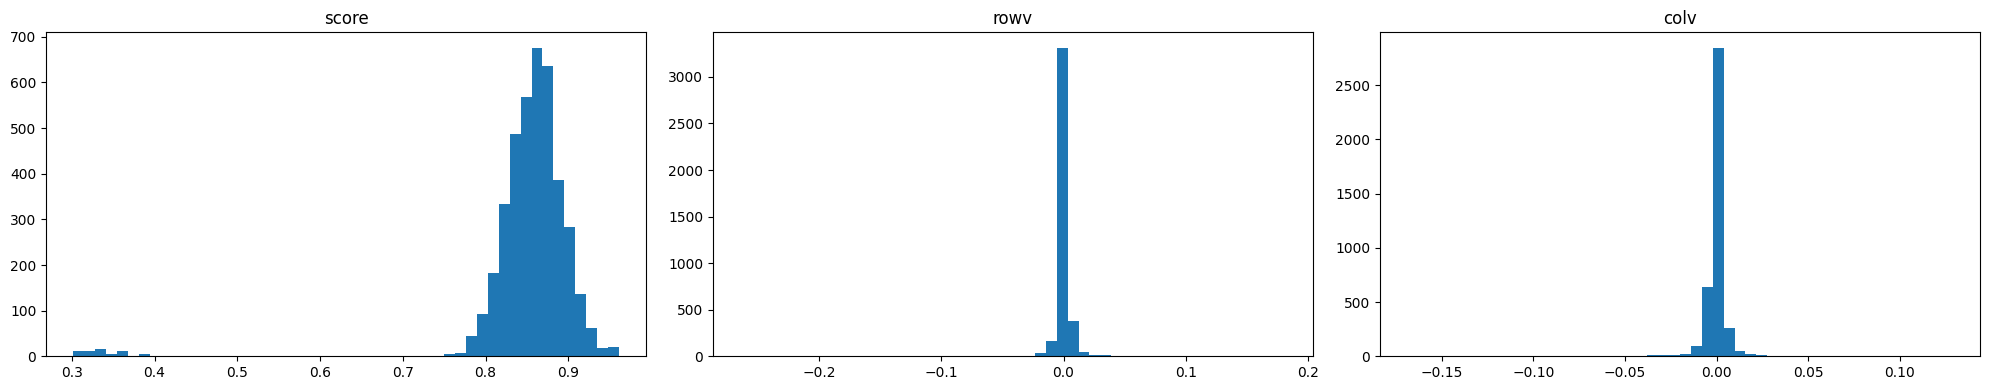

In [5]:
filter_features = ['score', 'rowv', 'colv']
fig, axis = plt.subplots(1, len(filter_features), tight_layout=True, figsize=(20,4))

for i, feature in enumerate(filter_features):
    axis[i].hist(describe_df[feature], bins=50)
    axis[i].set_title(feature)

plt.show()

### Análisis distribución redshift

Decidimos dedicarle su propia sección a la variable objetivo `redshift`. En este caso al realizar la gráfica de `redshift` contra `u`, una caracteristica, podemos observar dos grupos, una primera hipotesis podría ser pensar que son outliers. Por lo cual, se procederá a revisar los dos grupos que se pueden ver más de cerca.

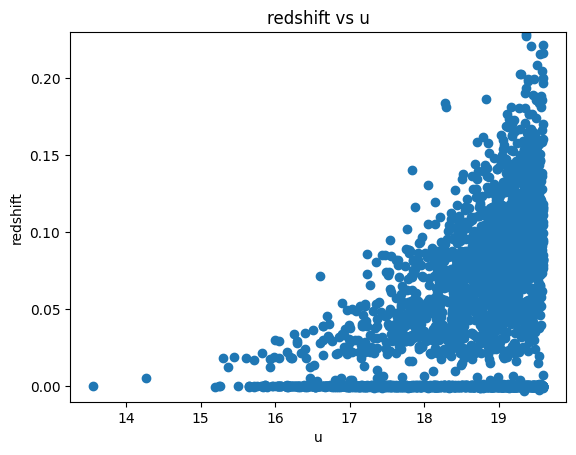

In [6]:
plt.scatter(star_df['u'], star_df['redshift'])
plt.ylim(-0.01, 0.23)
plt.title('redshift vs u')
plt.xlabel('u')
plt.ylabel('redshift')
plt.show()

Para hacer un análisis sobre el desplazamiento al rojo recordemos que el cuantil del 25% es 0.0001, esta magnitud continua hasta el cuantil del 44%. En el cuantil del 45% escalan a 0.001 y en el cuantil del 46% los datos dan un salto a 0.01. Esta tendencia continua hasta aproximadamente el cuantil del 80%, en el cual pasamos de un valor 0.0001 a 0.09. Luego, en el cuantil del 81% da un paso mas hacia 0.1 y en el cuantil del 96% hay nuevamente un salto hasta 1.25. 

In [7]:
q1 = star_df['redshift'].quantile(0.44)
q2 = star_df['redshift'].quantile(0.45)
q3 = star_df['redshift'].quantile(0.46)
q4 = star_df['redshift'].quantile(0.81)
q5 = star_df['redshift'].quantile(0.96)

q1, q2, q3, q4, q5

(np.float64(0.0007952765599999995),
 np.float64(0.0010524654499999991),
 np.float64(0.012371094600000009),
 np.float64(0.100893065),
 np.float64(1.2570427199999998))

Luego de ver esta tendencia podemos intentar revisar que sucede antes y después del cuantil del 95%, ya que a partir de este punto las magnitudes se vuelven cada vez más grandes. Comparemos lo que tenemos con la clase del cuerpo celeste.

De la ejecución del siguiente bloque de código se puede notar que el incremento en las magnitudes se debe a que mayormente los cuerpos con un redshift menor a aproximadamente 1 parecen ser estrellas y si es mayor parecen ser galaxias o cuásares. Por lo cual optamos por no podemos eliminar los datos ya que descartariamos una muestra representativa de los datos y además se sesgaria el algoritmo a que haga buenas predicciones de corrimiento al rojo de estrellas, pero no de galaxias y cuásares.

In [8]:
q = star_df['redshift'].quantile(0.95)
print(f'Cuantil: {q}\n')
print('Mayor a 1')
print(star_df[star_df['redshift'] > q2]['class'].value_counts())
print('\n' + '-'*30)
print('Menor a 1')
star_df[star_df['redshift'] < q2]['class'].value_counts()

Cuantil: 0.9817241999999968

Mayor a 1
class
GALAXY    1843
QSO        292
G           44
STAR        17
S            3
QUASAR       1
Name: count, dtype: int64

------------------------------
Menor a 1


class
STAR      1612
S          174
GALAXY      14
Name: count, dtype: int64

Al gráficar la distribución de la variable `redshift` notamos que la cola derecha es bastante pronunciada, por lo tanto, una buena manera de lidiar con esto sería hacer una transformación a estos datos. Esto se realizará en la sección de preprocesamiento.

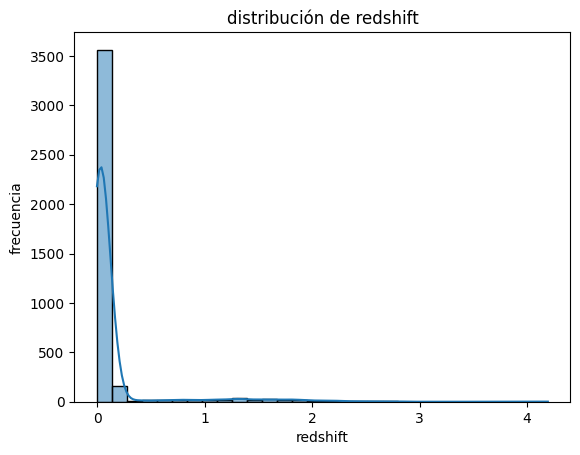

In [9]:
sns.histplot(star_df['redshift'], bins=30, kde=True)

plt.title('distribución de redshift')
plt.xlabel('redshift')
plt.ylabel('frecuencia')
plt.show() 

## Preselección de variables

En esta sección se descartan algunas carácteristicas y luego se realiza la matriz de correlación para hacer una preselección de las variables que pasaron el primer filtro.

En primer lugar vamos a descartar las variables que por lógica sabemos que no influyen en la predicción de la variable objetivo, verbigracia, el `objid` puesto que esta hace referencia al identificador de la toma, `camcol` porque se refiere a la columna de la cámara en la que se registró el objeto y no brinda información del objeto en sí, y lo mismo sucede con `field`, `mjd`, `run`, `clean`, que no nos aportan información sobre el objeto capturado sino sobre la toma, si bien variables como `clean` podemos tenerlo en cuenta a la hora de filtrar los datos debido a la confiabilidad de la toma y, asimismo tener presente la variable categorica `class` puesto que de la clasificación del objeto se puede inferir un comportamiento en el corrimiento, estas variables las tocaremos más adelante en la sección de Codificación y Análisis de calidad de datos.

['u', 'g', 'r', 'i', 'z', 'score', 'class', 'rowv', 'colv']


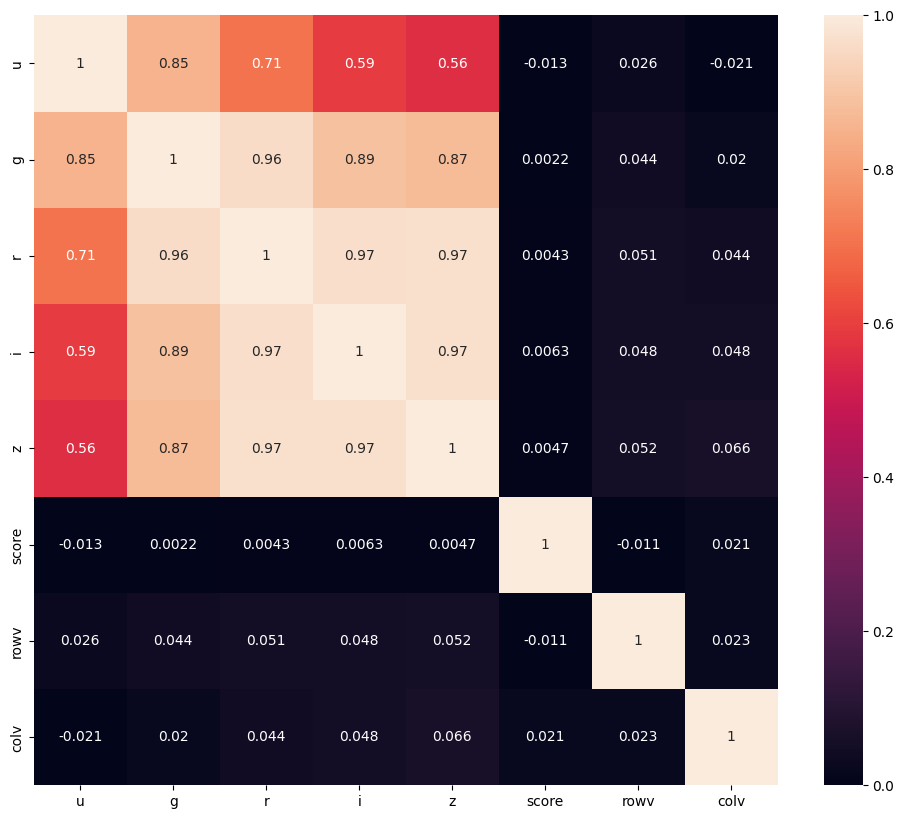

In [10]:
remove = ['objid', 'run', 'field', 'camcol', 'mjd', 'clean', 'redshift', 'ra', 'dec']
features = [x for x in list(star_df.columns) if x not in remove]
print(features)

#Removemos class puesto que es una varibale categorica
features.remove('class')

plt.figure(figsize=(12,10))
sns.heatmap(star_df[features].corr(), vmin=0, vmax=1, annot=True)
plt.show()

## Calidad de datos 

### Consistencia

En este punto es necesario revisar la consistencia entre los valores de la columna `class`. En esta se puede notar que hay mas clases de las que indica el diccionario de datos. Al hablar con la persona encargada de lo mismo se nos menciona que `Q` corresponde a `QUASAR`, `S` a `STAR` y `G` a `GALAXY`. Por otro lado, también es necesario verificar si la columna `clean` únicamente tiene valores de 0 y 1.

In [11]:
star_df["class"].value_counts()

class
GALAXY    1857
STAR      1629
QSO        292
S          177
G           44
QUASAR       1
Name: count, dtype: int64

In [12]:
star_df["clean"].value_counts()

clean
1    3582
0     418
Name: count, dtype: int64

### Validez
Además, se debe verificar que las columnas que tienen la magnitud del objeto según un filtro sea un valor mayor a 0. Además, el `score` este entre el rango 0 y 1. Lo cual se comprueba en la siguiente linea.

In [13]:
star_df[["u", "g", "r", "z", "i", "score", "run"]].describe()

,u,g,r,z,i,score,run
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,18.609049,17.363397,16.839856,16.439392,16.597712,0.851765,743.829000
std,0.839431,0.950964,1.055343,1.190502,1.141252,0.071311,98.865936
min,13.551780,12.974870,12.362850,11.799530,12.010790,0.301912,211.000000
25%,18.170375,16.796110,16.190785,15.628205,15.870782,0.836866,752.000000
50%,18.843745,17.472525,16.850835,16.402665,16.571195,0.860675,756.000000
75%,19.261563,17.997818,17.506640,17.147037,17.258833,0.879834,756.000000
max,19.599750,22.497450,22.265960,20.847690,28.179630,0.961145,1035.000000


Un proceso similar se realiza para las siguientes columnas, en las cuales no es lógico pensar en valores negativos. 

In [14]:
star_df[["camcol", "field", "mjd"]].describe()

,camcol,field,mjd
count,4000.00000,4000.000000,4000.000000
mean,3.37625,419.602000,52957.124750
std,1.69909,167.162063,1601.148131
min,1.00000,19.000000,51608.000000
25%,2.00000,311.000000,51821.000000
50%,3.00000,434.000000,51986.000000
75%,5.00000,527.000000,54468.000000
max,6.00000,812.000000,58932.000000


### Unicidad
Para verificar esta propiedad podemos apoyarnos de la columna `idobj` como se muestra a continuación. De la misma, se puede notar que hay 34 valores duplicados. Al detallar un poco más estos 34 datos se puede notar que efectivamente hay 2 registros por identificador. 

In [15]:
star_df.duplicated(subset='objid', keep=False).sum()

np.int64(34)

In [16]:
star_df.loc[star_df.duplicated(subset='objid', keep=False)].sort_values(by="objid")

,objid,ra,dec,u,g,r,i,z,run,camcol,field,score,clean,class,redshift,mjd,rowv,colv
114,1237646382079606869,94.679499,0.842321,18.47695,16.94897,16.68126,16.59887,16.51747,211,6,359,0.806204,1,STAR,0.000207,52931,0.000372,-0.001017
3024,1237646382079606869,94.679499,0.842321,18.47695,16.94897,16.68126,16.59887,16.51747,211,6,359,0.806204,1,STAR,0.000207,52931,0.000372,-0.001017
1735,1237646382079672642,94.883887,0.990686,17.03847,15.47224,15.10297,14.97051,14.88297,211,6,360,0.806983,1,S,0.000012,52931,-0.001483,0.001376
897,1237646382079672642,94.883887,0.990686,17.03847,15.47224,15.10297,14.97051,14.88297,211,6,360,0.806983,1,S,0.000012,52931,-0.001483,0.001376
88,1237648703513428079,206.374167,-0.781673,18.28101,17.18856,16.70175,16.33173,16.14626,752,2,420,0.904768,1,GALAXY,0.088136,51943,-0.002860,0.001156
3254,1237648703513428079,206.374167,-0.781673,18.28101,17.18856,16.70175,16.33173,16.14626,752,2,420,0.904768,1,GALAXY,0.088136,51943,-0.002860,0.001156
2609,1237648705132888168,226.621828,0.595329,18.96363,18.67637,18.47234,18.41949,17.96547,752,5,555,0.871417,1,QSO,0.369813,51990,0.002106,-0.000110
3592,1237648705132888168,226.621828,0.595329,18.96363,18.67637,18.47234,18.41949,17.96547,752,5,555,0.871417,1,QSO,0.369813,51990,0.002106,-0.000110
1991,1237648705134461016,230.219374,0.560741,19.42733,19.27966,19.59048,19.86852,20.08571,752,5,579,0.875917,1,STAR,-0.000112,55327,-0.000059,0.000094
1533,1237648705134461016,230.219374,0.560741,19.42733,19.27966,19.59048,19.86852,20.08571,752,5,579,0.875917,1,STAR,-0.000112,55327,-0.000059,0.000094


### Completitud
En este caso los datos se encuentran completos y por lo tanto no tenemos problemas con este aspecto.

In [17]:
star_df.isna().sum()

objid       0
ra          0
dec         0
u           0
g           0
r           0
i           0
z           0
run         0
camcol      0
field       0
score       0
clean       0
class       0
redshift    0
mjd         0
rowv        0
colv        0
dtype: int64

# 2. Solucion de problemas de calidad de datos y preprocesamiento

## Problemas de calidad

Para solucionar los problemas de consistencia se puede unicamente reemplazar los valores del conjunto de datos con sus respectivos valores.

In [18]:
def solve_consistency(dataframe: pd.DataFrame) -> None:
    dataframe.replace(
        to_replace={'QSO': 'QUASAR', 'S': 'STAR', 'G': 'GALAXY'},
        inplace=True
    )

solve_consistency(star_df)
star_df['class'].value_counts()

class
GALAXY    1901
STAR      1806
QUASAR     293
Name: count, dtype: int64

En cuanto a la unicidad se puede eliminar uno de los dos resgistros que tengan identificadores iguales.

In [19]:
def solve_unicity(dataframe: pd.DataFrame) -> None:
    dataframe.drop_duplicates(subset='objid', keep='first', inplace=True)

solve_unicity(star_df)
star_df.duplicated(subset='objid', keep=False).sum()

np.int64(0)

## Preprocesamiento

Teniendo lo anterior en cuenta se opta por realizar una transformación cubica a los datos ya que contamos con números negativos. Al realizar esto ahora obtenemos una distribución trimodal, lo cual pronuncia más la división de los datos en tres clases.

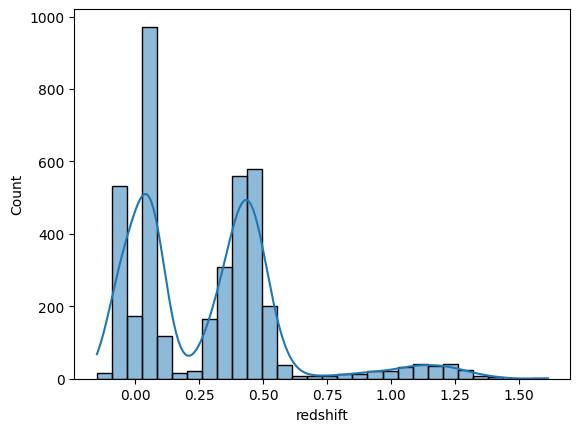

In [20]:
trans_redshift = np.cbrt(star_df['redshift'])

sns.histplot(trans_redshift, bins=30, kde=True)
plt.show()

Al realizar una gráfica de este redshift con la transformación contra una carácteristica u notamos que los tres grupos ahora estan bastante más pronunciados y ahora tampoco se ve una relación lineal entre las variables. En este punto decidimos guardar estos datos transformados para hacer un modelo mas adelante y probar su desempeño.

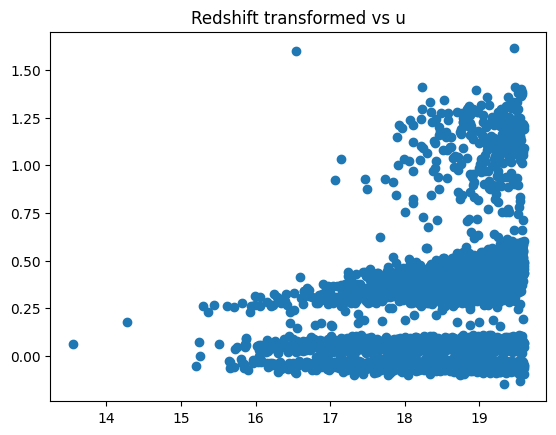

In [21]:
plt.scatter(star_df['u'], trans_redshift)
plt.title('Redshift transformed vs u')
plt.show()

### Escalamiento de los datos

En esta parte se realiza el escalamiento de los datos utilizando la clase `StandardScaler`.

In [22]:
sc = StandardScaler()

scaled = sc.fit_transform(star_df[features])
star_df_scaled = pd.DataFrame(
    scaled,
    columns=features,
    index=star_df.index
)

star_df_scaled

,u,g,r,i,z,score,rowv,colv
0,0.597335,0.271117,0.184916,0.203783,0.233529,0.173451,0.249874,0.194955
1,0.358083,0.279966,0.165967,0.020307,-0.072881,-0.493036,0.957236,0.957301
2,0.779732,0.329975,-0.013321,-0.152810,-0.252457,0.260766,0.422372,-0.259147
3,0.251607,0.435950,0.517738,0.450373,0.416919,0.224645,0.184156,0.167756
4,0.363254,1.778414,2.486584,2.768865,3.072321,-0.251054,0.194414,-0.049841
...,...,...,...,...,...,...,...,...
3995,0.250034,0.557034,0.667480,0.715367,0.738527,0.504684,0.052081,0.055783
3996,-1.361405,-1.475033,-1.402366,-1.272344,-1.171644,-0.097026,-0.074562,-0.027939
3997,1.010225,1.012434,0.975969,0.856905,0.821086,-0.456501,1.263562,0.796378
3998,0.706063,-0.051363,-0.449153,-0.595829,-0.724002,0.592066,-0.533747,-0.800687


### Codificación

En esta parte haremos dos cosas principalmente, la primera es usar `OneHotEncoder` para codificar la columna categorica `class` y la segunda es hacer una escalamiento de los datos utilizando `MinMaxScaler` para que el algoritmo trabaje sobre rangos bien definidos. 

In [23]:
class_encoder = OneHotEncoder()

class_encoded = class_encoder.fit_transform(star_df[['class']]).toarray()
column_encoded = pd.DataFrame(
    class_encoded,
    columns=class_encoder.get_feature_names_out(['class']),
    index=star_df.index
)
column_encoded

,class_GALAXY,class_QUASAR,class_STAR
0,0.0,0.0,1.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,0.0,0.0,1.0
...,...,...,...
3995,0.0,0.0,1.0
3996,0.0,0.0,1.0
3997,1.0,0.0,0.0
3998,1.0,0.0,0.0


In [24]:
df_transformed = pd.concat([star_df[features], column_encoded], axis=1)
df_transformed.drop(columns=['class_QUASAR'], inplace=True)
df_transformed.head(4)

,u,g,r,i,z,score,rowv,colv,class_GALAXY,class_STAR
0,19.11034,17.62099,17.03464,16.82993,16.71711,0.864145,0.002418,0.001363,0.0,1.0
1,18.90957,17.62940,17.01465,16.62059,16.35239,0.816541,0.008650,0.007056,1.0,0.0
2,19.26340,17.67693,16.82551,16.42307,16.13864,0.870381,0.003938,-0.002028,1.0,0.0
3,18.82022,17.77765,17.38575,17.11128,16.93540,0.867801,0.001839,0.001160,1.0,0.0


# Modelado

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    df_transformed,
    star_df["redshift"],
    test_size=0.3,
    random_state=42
)

In [26]:
regression = LinearRegression()
regression.fit(X_train, y_train)

LinearRegression()

In [27]:
# AUN NO SE HA IMPORTADO
# cross_val_score(regression, X_test, y_test, cv=2)

## Revisión parámetros del modelo

In [28]:
pd.DataFrame({'columns': df_transformed.columns, 'coef': regression.coef_})

,columns,coef
0,u,-0.005570
1,g,-0.006367
2,r,0.040076
3,i,0.001879
4,z,-0.015611
5,score,0.062326
6,rowv,-0.233110
7,colv,0.272470
8,class_GALAXY,-1.158782
9,class_STAR,-1.240182


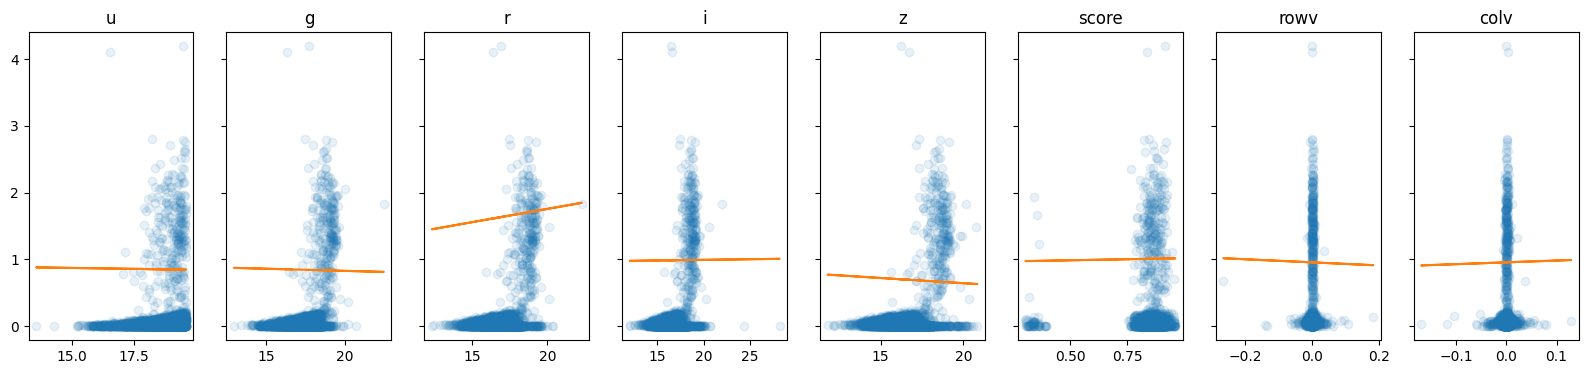

In [29]:
f, axs = plt.subplots(1, len(df_transformed.columns) -2, sharey=True, figsize=(20, 4))

for i in range(len(df_transformed.columns)):
    if "class" in df_transformed.columns[i]:
        continue

    col = df_transformed.columns[i]
    x = df_transformed[col]
    m = regression.coef_[i]
    b = regression.intercept_

    axs[i].plot(x, star_df['redshift'], "o", alpha=0.1)
    axs[i].plot(x, x * m + b)
    axs[i].set_title(col)

plt.show()

In [30]:
print("Train:", mean_absolute_error(y_train, regression.predict(X_train)))
print("Test:", mean_absolute_error(y_test, regression.predict(X_test)))

Train: 0.05896706544263273
Test: 0.060419638439377345


In [31]:
print("Train:", np.sqrt(mean_squared_error(y_train, regression.predict(X_train))))
print("Test:", np.sqrt(mean_squared_error(y_test, regression.predict(X_test))))

Train: 0.1890594916233969
Test: 0.17954222963640645


In [32]:
print(r2_score(y_train, regression.predict(X_train)))
r2_score(y_test, regression.predict(X_test))

0.747282442235347


0.7884883354241905

### 4) Evaluación cuantitativa: A partir de las métricas seleccionadas para evaluar y seleccionar el mejor modelo, explicar el resultado obtenido desde el punto de vista cuantitativo. Contestar a la pregunta: ¿Su equipo recomienda utilizar en producción el modelo de regresión para estimar el corrimiento al rojo? ¿Por qué? En caso de no recomendar el uso del modelo, ¿qué recomendaciones haría para continuar iterando con el objetivo de la construcción de un mejor modelo?

# Evaluación Cuantitativa del Modelo de Regresión para Predecir el Corrimiento al Rojo

## 1. Análisis de las métricas obtenidas  
El modelo fue evaluado utilizando tres métricas principales:  

- **Error Absoluto Medio (MAE)**  
  - Train: **0.0589**  
  - Test: **0.0604**  
  - Un MAE bajo indica que, en promedio, el error en la predicción del corrimiento al rojo es pequeño.  

- **Raíz del Error Cuadrático Medio (RMSE)**  
  - Train: **0.1890**  
  - Test: **0.1795**  
  - El RMSE también es bajo, lo que sugiere que el modelo tiene un error bajo en sus predicciones.  

- **Coeficiente de determinación (R²)**  
  - Train: **0.7473**  
  - Test: **0.7848**  
  - Un R² cercano a 1 indica que el modelo explica bien la variabilidad de los datos.  
  - En este caso, el **78.48% de la varianza en el conjunto de prueba es explicada por el modelo**, lo que sugiere un buen ajuste.  

## 2. ¿Se recomienda utilizar este modelo en producción?  

- El **R² en test (0.7848)** sugiere que el modelo generaliza bien y captura una gran parte de la variabilidad del corrimiento al rojo.  
- **La diferencia entre las métricas de entrenamiento y prueba es mínima**, lo que indica que el modelo no está sobreajustado ni subajustado.  
- **Errores relativamente bajos (MAE y RMSE)** refuerzan la confiabilidad del modelo.  

Por lo tanto, **sí recomendaría usarlo en producción**, aunque con algunas mejoras.

## 3. Recomendaciones para mejorar el modelo  

- **Ingeniería de Características**: Explorar la transformación de variables o la creación de nuevas características relevantes.  
- **Explorar otros modelos**: Podriamo probar modelos como Random Forest, Gradient Boosting o redes neuronales para comparar su desempeño.  
- **Aumentar la cantidad y calidad de datos**: Si es posible, recopilar más datos para mejorar la capacidad de generalización del modelo.  

### 5)Evaluación cualitativa: Debe estar compuesta de dos partes:

#### a) Validación de supuestos: Realizar los ajustes necesarios para que el modelo cumpla con los supuestos necesarios para la inferencia estadística con regresiones.

#### 5.1) Colinealidad
Las variables no deben estar correlación, o que esta sea muy baja.

<Axes: >

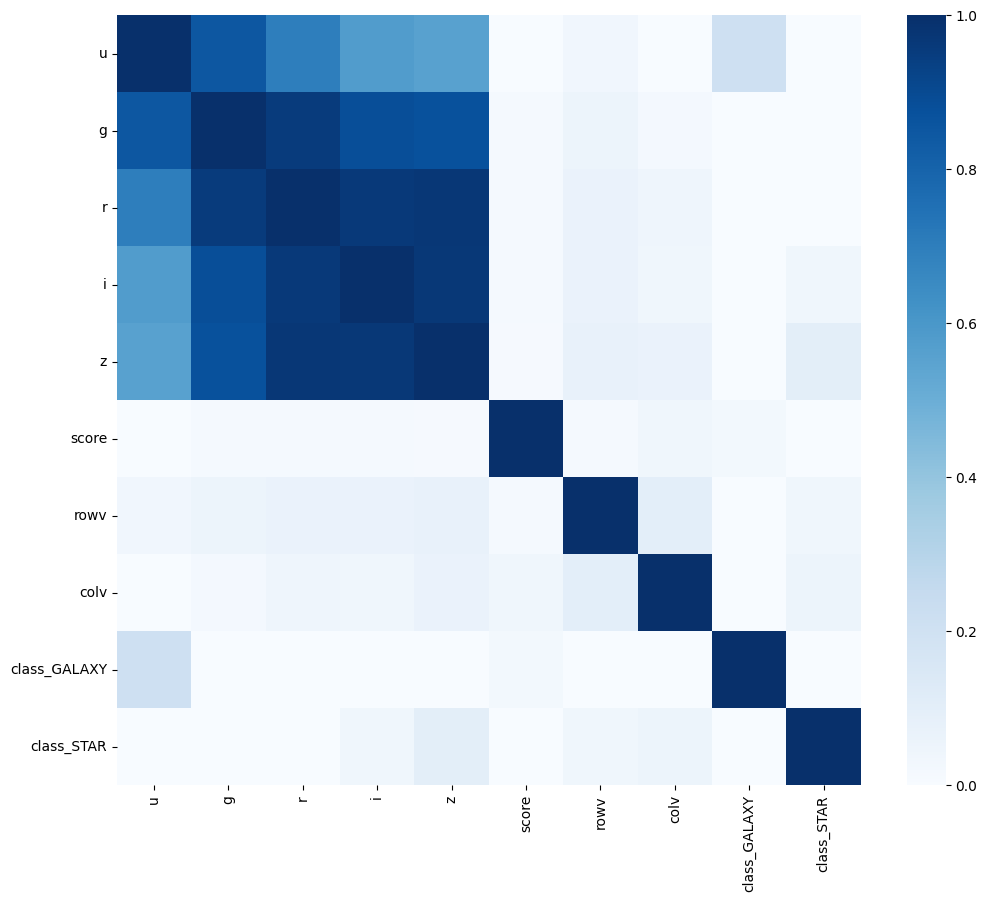

In [33]:
plt.figure(figsize=(12, 10))
sns.heatmap(X_train.corr(), cmap="Blues", vmin=0, vmax=1)

In [34]:
X_train.corr()

,u,g,r,i,z,score,rowv,colv,class_GALAXY,class_STAR
u,1.000000,0.848441,0.701762,0.581451,0.555640,-0.001156,0.038895,-0.030201,0.207836,-0.275174
g,0.848441,1.000000,0.956966,0.884849,0.873798,0.017286,0.056270,0.019796,-0.016578,-0.196174
r,0.701762,0.956966,1.000000,0.964036,0.970648,0.017979,0.067115,0.043332,-0.177071,-0.058983
i,0.581451,0.884849,0.964036,1.000000,0.967425,0.017729,0.066818,0.040915,-0.273262,0.039386
z,0.555640,0.873798,0.970648,0.967425,1.000000,0.015304,0.076107,0.067892,-0.340103,0.105158
score,-0.001156,0.017286,0.017979,0.017729,0.015304,1.000000,0.018492,0.039184,0.026320,-0.045506
rowv,0.038895,0.056270,0.067115,0.066818,0.076107,0.018492,1.000000,0.100613,-0.055344,0.039524
colv,-0.030201,0.019796,0.043332,0.040915,0.067892,0.039184,0.100613,1.000000,-0.084142,0.055842
class_GALAXY,0.207836,-0.016578,-0.177071,-0.273262,-0.340103,0.026320,-0.055344,-0.084142,1.000000,-0.862324
class_STAR,-0.275174,-0.196174,-0.058983,0.039386,0.105158,-0.045506,0.039524,0.055842,-0.862324,1.000000


En este caso decidimos eliminar a `r` puesto es casi redundante con `i`.

In [51]:
features2 = ['u','g','i','z','score','rowv','colv','class_GALAXY','class_STAR']

In [52]:
X_train[features2].corr()

,u,g,i,z,score,rowv,colv,class_GALAXY,class_STAR
u,1.000000,0.848441,0.581451,0.555640,-0.001156,0.038895,-0.030201,0.207836,-0.275174
g,0.848441,1.000000,0.884849,0.873798,0.017286,0.056270,0.019796,-0.016578,-0.196174
i,0.581451,0.884849,1.000000,0.967425,0.017729,0.066818,0.040915,-0.273262,0.039386
z,0.555640,0.873798,0.967425,1.000000,0.015304,0.076107,0.067892,-0.340103,0.105158
score,-0.001156,0.017286,0.017729,0.015304,1.000000,0.018492,0.039184,0.026320,-0.045506
rowv,0.038895,0.056270,0.066818,0.076107,0.018492,1.000000,0.100613,-0.055344,0.039524
colv,-0.030201,0.019796,0.040915,0.067892,0.039184,0.100613,1.000000,-0.084142,0.055842
class_GALAXY,0.207836,-0.016578,-0.273262,-0.340103,0.026320,-0.055344,-0.084142,1.000000,-0.862324
class_STAR,-0.275174,-0.196174,0.039386,0.105158,-0.045506,0.039524,0.055842,-0.862324,1.000000


In [53]:
regression.fit(X_train[features2], y_train)

LinearRegression()

In [54]:
print("Train:", mean_absolute_error(y_train, regression.predict(X_train[features2])))
print("Test:", mean_absolute_error(y_test, regression.predict(X_test[features2])))

Train: 0.05889018837276962
Test: 0.060397993465229984


In [55]:
print("Train:", np.sqrt(mean_squared_error(y_train, regression.predict(X_train[features2]))))
print("Test:", np.sqrt(mean_squared_error(y_test, regression.predict(X_test[features2]))))

Train: 0.18908703328945958
Test: 0.1797545171318527


In [56]:
print(r2_score(y_train, regression.predict(X_train[features2])))
r2_score(y_test, regression.predict(X_test[features2]))

0.7472088064765674


0.7879878645672301

#### 5.2) Linealidad
Necesitamos que la relacion entre cada una de las varibales con la objetivo `redshift` sea linal

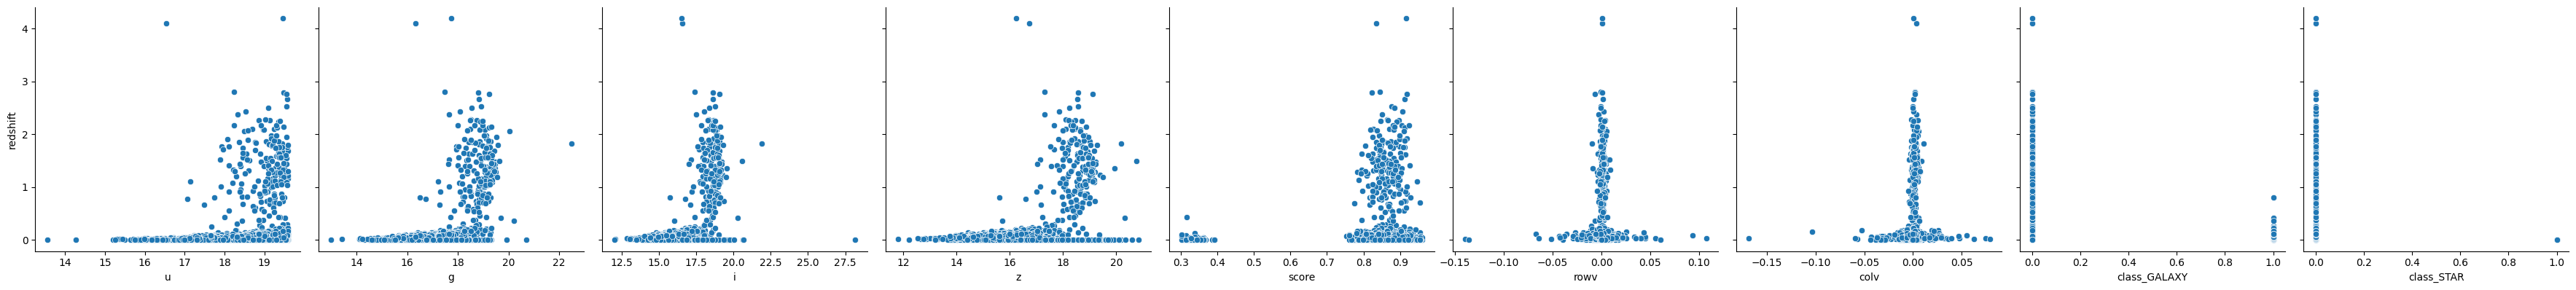

In [59]:
sns.pairplot(pd.concat([X_train, y_train], axis=1), height=4, y_vars="redshift", x_vars=features2, kind="scatter")

Debido a la relacion no lineal que encontramos en todas las variables con la objetivo. Decidimos aplicar una transformacion polinomial a todas las variables y que sea labor del algoritmo decidir cuales son las mas relevantes para la estimacion.

In [64]:
# Create polynomial features pipeline
poly_pipeline = Pipeline([
    ('scaler1', StandardScaler()),  # Escalado inicial
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),  # Características polinomiales
    ('scaler2', StandardScaler())  # Escalado después de la transformación polinomial
])

# Transformar las características
X_train_poly = poly_pipeline.fit_transform(X_train[features2])
X_test_poly = poly_pipeline.transform(X_test[features2])

# Ajustar regresión lineal con características polinomiales
poly_regression = LinearRegression()
poly_regression.fit(X_train_poly, y_train)

# Imprimir métricas
print("Train MAE:", mean_absolute_error(y_train, poly_regression.predict(X_train_poly)))
print("Test MAE:", mean_absolute_error(y_test, poly_regression.predict(X_test_poly)))
print("\nTrain RMSE:", np.sqrt(mean_squared_error(y_train, poly_regression.predict(X_train_poly))))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, poly_regression.predict(X_test_poly))))
print("\nTrain R2:", r2_score(y_train, poly_regression.predict(X_train_poly)))
print("Test R2:", r2_score(y_test, poly_regression.predict(X_test_poly)))

Train MAE: 0.05841904283741373
Test MAE: 0.06933520098078243

Train RMSE: 0.17451354952577208
Test RMSE: 0.23148065756108285

Train R2: 0.7846738633813479
Test R2: 0.6484148611615101


#### 5.3) Normalidad de los errores

Train MAE: 0.05841904283741373
Test MAE: 0.06933520098078243

Train RMSE: 0.17451354952577208
Test RMSE: 0.23148065756108285

Train R2: 0.7846738633813479
Test R2: 0.6484148611615101


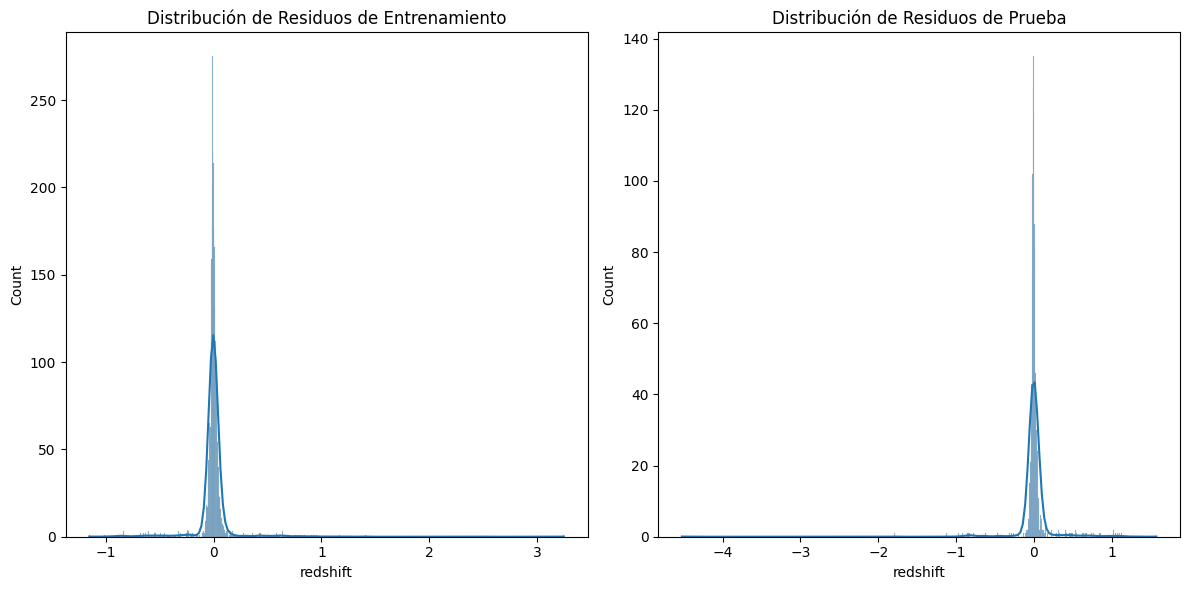

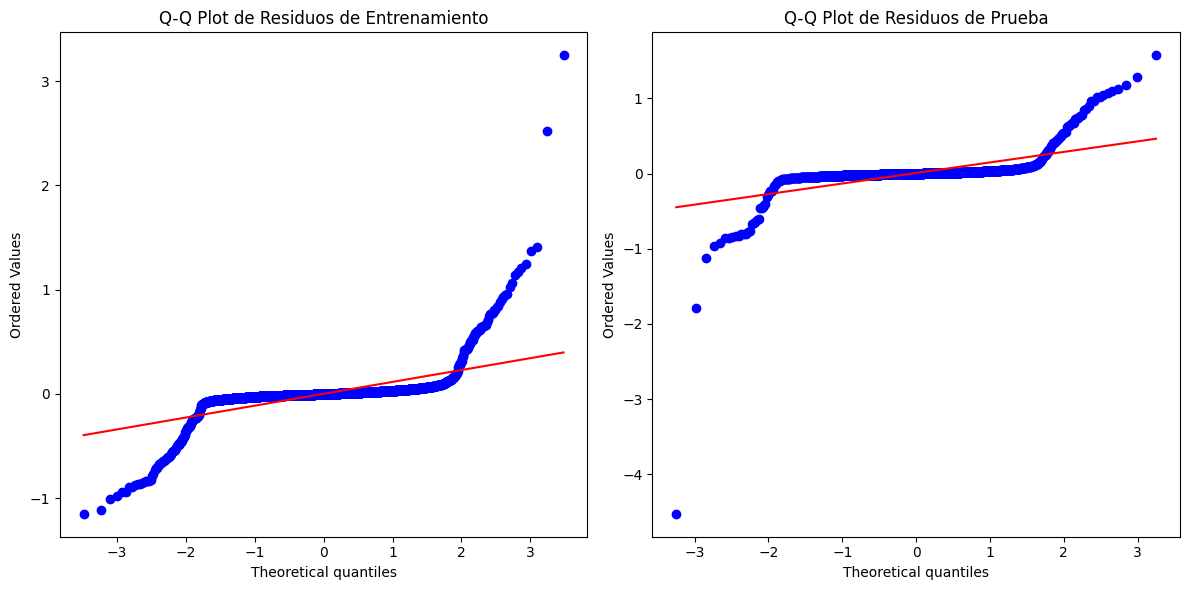


Prueba de Shapiro-Wilk para residuos de entrenamiento:
Estadístico: 0.42820859689806345, p-valor: 2.63361587917639e-69

Prueba de Shapiro-Wilk para residuos de prueba:
Estadístico: 0.3712161983075466, p-valor: 2.500321328336753e-53


In [ ]:
from scipy.stats import shapiro, probplot

# Crear pipeline de características polinomiales
poly_pipeline = Pipeline([
    ('scaler1', StandardScaler()),  # Escalado inicial
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),  # Características polinomiales
    ('scaler2', StandardScaler())  # Escalado después de la transformación polinomial
])

# Transformar las características
X_train_poly = poly_pipeline.fit_transform(X_train[features2])
X_test_poly = poly_pipeline.transform(X_test[features2])

# Ajustar regresión lineal con características polinomiales
poly_regression = LinearRegression()
poly_regression.fit(X_train_poly, y_train)

# Imprimir métricas
print("Train MAE:", mean_absolute_error(y_train, poly_regression.predict(X_train_poly)))
print("Test MAE:", mean_absolute_error(y_test, poly_regression.predict(X_test_poly)))
print("\nTrain RMSE:", np.sqrt(mean_squared_error(y_train, poly_regression.predict(X_train_poly))))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, poly_regression.predict(X_test_poly))))
print("\nTrain R2:", r2_score(y_train, poly_regression.predict(X_train_poly)))
print("Test R2:", r2_score(y_test, poly_regression.predict(X_test_poly)))

# Calcular los residuos
train_residuals = y_train - poly_regression.predict(X_train_poly)
test_residuals = y_test - poly_regression.predict(X_test_poly)

# Visualizar los residuos
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(train_residuals, kde=True)
plt.title('Distribución de Residuos de Entrenamiento')

plt.subplot(1, 2, 2)
sns.histplot(test_residuals, kde=True)
plt.title('Distribución de Residuos de Prueba')

plt.tight_layout()
plt.show()

# Gráfico Q-Q
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
probplot(train_residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot de Residuos de Entrenamiento')

plt.subplot(1, 2, 2)
probplot(test_residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot de Residuos de Prueba')

plt.tight_layout()
plt.show()

# Prueba de Shapiro-Wilk
shapiro_train = shapiro(train_residuals)
shapiro_test = shapiro(test_residuals)

print("\nPrueba de Shapiro-Wilk para residuos de entrenamiento:")
print(f"Estadístico: {shapiro_train.statistic}, p-valor: {shapiro_train.pvalue}")

print("\nPrueba de Shapiro-Wilk para residuos de prueba:")
print(f"Estadístico: {shapiro_test.statistic}, p-valor: {shapiro_test.pvalue}")

Residuos de Entrenamiento:

El estadístico de Shapiro-Wilk es 0.4282, que está muy lejos de 1.
El p-valor es extremadamente bajo (2.63361587917639e-69), mucho menor que 0.05.
Esto indica que los residuos de entrenamiento no siguen una distribución normal.
Residuos de Prueba:

El estadístico de Shapiro-Wilk es 0.3712, que también está muy lejos de 1.
El p-valor es extremadamente bajo (2.500321328336753e-53), mucho menor que 0.05.
Esto indica que los residuos de prueba no siguen una distribución normal.

#### b) Interpretación de los coeficientes: Realizar la interpretación de los coeficientes de la regresión, identificando las variables más relevantes para la estimación y cómo afectan la variable objetivo.

Pudimos notar que el Train R^2 ha mejorado indicando que el modelo polinomial ajusta mejor los datos de entrenamiento, sin embargo, el test R^2 disminuyo lo que sugiere que el modelo podria estar overfitted. Esto puede deberse a la alta colinealidad de las variables y a la relacion que tienen las variables que no es lineal y no parece ser logaritmica tampoco

### 6) Presentación de los resultados: Mostrar el resultado obtenido con el modelo de regresión en una presentación corta que justifique si éste puede ayudar a cumplir el objetivo de la organización.

### 7) Exportar el mejor modelo (utilizando pipelines) para poder ser usado sobre datos nuevos en el ambiente de producción del cliente.

### 8) Generar predicciones sobre los datos de prueba que no se encuentran etiquetados utilizando el mejor modelo. Exportar las predicciones en formato CSV utlizando como base el mismo archivo de datos de prueba.

In [ ]:
import pandas as pd
import joblib

modelo = joblib.load("pipeline_entrenado.pkl")

df_test = pd.read_csv("validation_data.csv") 

if 'ID' in df_test.columns:
    ids = df_test['ID']
else:
    ids = None

X_test = df_test.drop(columns=['corrimiento_al_rojo'], errors='ignore') 

predicciones = modelo.predict(X_test)

df_resultado = df_test.copy()
df_resultado["corrimiento_al_rojo_predicho"] = predicciones

df_resultado.to_csv("predicciones.csv", index=False)

print("✅ Predicciones guardadas en 'predicciones.csv'")
